## 简单题
1. 如果你的训练集有数百万个特征，可以使用随机梯度下降（Stochastic Gradient Descent）或小批量梯度下降（Mini-batch Gradient Descent），在内存中训练模型；但不能使用正规方程（Normal Equation）或 SVD 方法，因为它们的计算复杂度随着特征数的平方甚至更高增长，计算量会非常大。

2. 如果训练集中的特征具有非常不同的尺度，代价函数的形状会像一个细长的碗，梯度下降算法收敛会非常慢。为了解决这个问题，你应该在训练模型前对数据进行缩放。注意，如果使用正规方程或 SVD 方法，则无需缩放。此外，如果未缩放特征，正则化模型可能会收敛到次优解：因为正则化会惩罚权重较大的特征，尺度较小的特征相较于尺度较大的特征更容易被忽略。

3. 在训练逻辑回归模型时，梯度下降不会陷入局部最小值，因为代价函数是凸的。凸（convex）意味着如果你在曲线上任意两点之间画一条直线，这条直线不会低于曲线。

4. 如果优化问题是凸的（例如线性回归或逻辑回归），且学习率不太高，那么所有梯度下降算法都会收敛到全局最优解，并产生非常相似的模型。然而，除非逐渐降低学习率，否则随机梯度下降和小批量梯度下降将永远无法真正收敛；它们会在全局最优解附近不断来回摆动。如果运行很长时间，这些算法会产生略有不同的模型。

5. 如果验证误差在每个 epoch 后都在增加，一种可能是学习率太高，算法正在发散。如果训练误差也增加，这很明显是学习率过高，应当降低学习率。如果训练误差不增加，但验证误差持续上升，说明模型过拟合，应停止训练。

6. 由于其随机性，随机梯度下降或小批量梯度下降不能保证在每次训练迭代中都取得进展。因此，如果验证误差上升时立即停止训练，可能会过早终止，导致未达到最优解。更好的方法是在固定间隔保存模型，当验证误差长时间未改善时（意味着可能不会再刷新最优值），可以恢复到保存的最佳模型。

7. 随机梯度下降由于每次只考虑一个训练样本（或小批量梯度下降中使用非常小的批量大小），通常最快到达全局最优解附近。然而，只有批量梯度下降最终能真正收敛（在足够长的训练时间下）。随机梯度下降和小批量梯度下降会在最优解附近来回摆动，除非逐渐降低学习率。

8. 如果验证误差远高于训练误差，说明模型可能过拟合训练集。解决方法之一是降低多项式的阶数：自由度较低的模型更不容易过拟合。另外，你也可以通过正则化模型来减少过拟合，例如加入 L2 惩罚（Ridge）或 L1 惩罚（Lasso），这也会减少模型的自由度。最后，还可以尝试增加训练集大小。

9. 如果训练误差和验证误差都很高且接近，说明模型可能欠拟合，这意味着高偏差。你应该尝试降低正则化超参数 α。

10. 说明：
    - 具有一些正则化的模型通常比没有正则化的模型表现更好，因此应优先选择岭回归（Ridge Regression）而不是线性回归（Linear Regression）。
    - Lasso 回归使用 L1 惩罚，会将某些权重推到恰好为零，从而得到稀疏模型（只有少数重要特征的权重非零）。这是一种自动特征选择方法，如果你怀疑只有少数特征真正重要，可以尝试。如果不确定，应优先选择 Ridge 回归。
    - 弹性网（Elastic Net）一般优于 Lasso，因为当特征强相关或特征数大于样本数时，Lasso 表现不稳定。不过，Elastic Net 多了一个需要调整的超参数。如果你想要 Lasso 的稀疏性又想避免其不稳定性，可以使用 `l1_ratio` 接近 1 的 Elastic Net。

11. 如果你想分类图片是户外/室内，以及白天/夜晚（这些不是互斥类别，即四种组合都可能存在），你应该训练两个逻辑回归分类器。

In [1]:
from sklearn.datasets import load_iris
import numpy as np

In [2]:
iris = load_iris(as_frame=True)
iris.data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [3]:
X, y = iris.data[['petal length (cm)', 'petal width (cm)']].values, iris.target.values

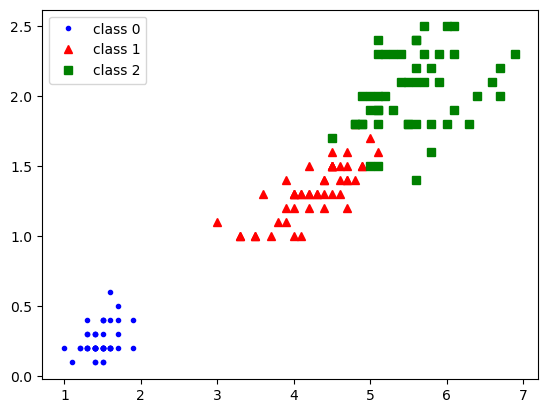

In [4]:
import matplotlib.pyplot as plt

plt.plot(X[y==0, 0], X[y==0, 1], "b.", label="class 0")
plt.plot(X[y==1, 0], X[y==1, 1], "r^", label="class 1")
plt.plot(X[y==2, 0], X[y==2, 1], "gs", label="class 2")
plt.legend()
plt.show()

In [5]:
def cross_entropy(y_true, y_pred):
    # y_pred: m,k
    # y_true: m,
    m = len(y_true)
    y_true = y_true.reshape(-1,1)  # (m,1)

    result = np.sum((y_true == np.unique(y_true).reshape(1,-1)) * np.log(y_pred)) / (-m)
    return result

def cross_entropy_l2(y_true, y_pred, alpha, w):
    return cross_entropy(y_true, y_pred) + alpha * np.sum(w**2)

def softmax_predict(X, w ,b):
    # X: m*n
    # w: n*k
    # b: k,
    s = X@w  + b# m,k
    exps = np.exp(s) # m,k
    return exps / np.sum(exps, axis=1, keepdims=True)

def softmax_gradient(X, y_true, w, b, alpha=0):
    # 返回dw 和 db
    # X: m,n
    # y_true: m,
    # w: n,k
    # b, k,
    # dw形状：(n, k)
    # db形状：(k,)
    # alpha=0: l2正则化的强度
    m = len(y_true)
    p = softmax_predict(X, w, b)
    y_true = y_true.reshape(-1,1)
    y_true = y_true == np.unique(y_true).reshape(1,-1)  # m,k
    dw = X.T @ (p - y_true) / m + 2*alpha*w
    db = np.sum(p-y_true, axis=0) / m
    return dw, db

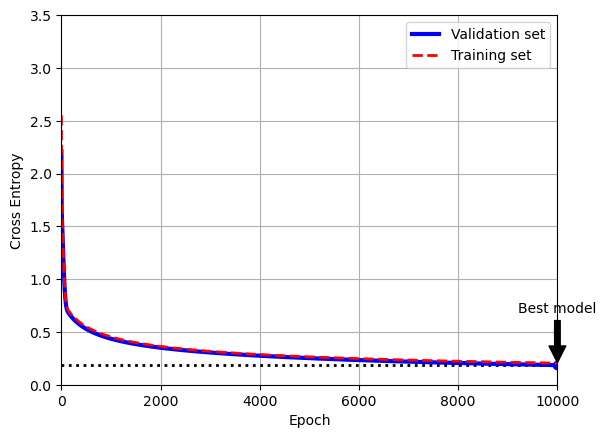

In [6]:
n_epoches = 10000
learning_rate = 0.03
alpha = 0

m, n = X.shape
k = len(np.unique(y))

np.random.seed(100)
w_init = np.random.randn(n,k)
b_init = np.random.randn(k)

w = w_init
b = b_init


rnd_indices = np.random.permutation(m)
valid_ratio = 0.3
valid_size = int(m*valid_ratio)
train_size = m - valid_size

X = X[rnd_indices]
y = y[rnd_indices]
X_train, X_valid = X[:train_size], X[train_size:]
y_train, y_valid = y[:train_size], y[train_size:]

best_valid_loss = float('inf')
w_best = w_init.copy()
b_best = b_init.copy()

train_errors, valid_errors = [], []
best_epoch = 0

for i in range(n_epoches):
    dw, db = softmax_gradient(X_train, y_train, w, b, alpha=alpha/m)
    w -= learning_rate * dw
    b -= learning_rate * db

    y_pred_valid = softmax_predict(X_valid, w, b)
    loss_valid = cross_entropy(y_valid, y_pred_valid)

    # 早停逻辑
    if loss_valid < best_valid_loss:
        best_valid_loss = loss_valid
        w_best = w.copy()
        b_best = b.copy()
        best_epoch = i + 1

    y_pred_train = softmax_predict(X_train, w, b)
    loss_train = cross_entropy_l2(y_train, y_pred_train, alpha/m, w)
    train_errors.append(loss_train)
    valid_errors.append(loss_valid)

# 在图里 画注释
plt.annotate('Best model',
             xy=(best_epoch, best_valid_loss),
             xytext=(best_epoch, best_valid_loss + 0.5),
             ha="center",   # 水平方向对齐方式
             arrowprops=dict(facecolor='black', shrink=0.05))   # arrowprops 字典中的一个键，用来设置箭头两端的“收缩比例”，即让箭头稍微不完全连接起点 xy 和终点 xytext

plt.plot([0, n_epoches], [best_valid_loss, best_valid_loss], "k:", linewidth=2)  # 横线
plt.plot(valid_errors, "b-", linewidth=3, label="Validation set")                 # 验证误差折线
plt.plot(best_epoch, best_valid_loss, "bo")                                     # 最佳验证误差的点
plt.plot(train_errors, "r--", linewidth=2, label="Training set")                # 训练误差折线
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.axis([0, n_epoches, 0, 3.5])
plt.grid()
plt.show()

In [7]:
y_train_pred = np.argmax(softmax_predict(X_train, w_best, b), axis=1)
(y_train_pred== y_train).mean()

0.9523809523809523

In [8]:
y_valid_pred = np.argmax(softmax_predict(X_valid, w_best, b), axis=1)
(y_valid_pred == y_valid).mean()

0.9777777777777777